# General Setup

In [ ]:
!pip install 'torch-lr-finder==0.2.0'
!rm -vrf '/content/tobit_loss'
!git clone https://github.com/vlad-danaila/tobit_loss.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'tobit_loss'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 154 (delta 92), reused 95 (delta 43), pack-reused 0
Receiving objects: 100% (154/154), 33.09 KiB | 8.27 MiB/s, done.
Resolving deltas: 100% (92/92), done.


Add the Tobit loss to Python path.

In [ ]:
import sys
sys.path.insert(0, '/content/tobit_loss')

Imports

In [ ]:
import torch as t
from deep_tobit.util import to_torch, to_numpy, normalize, unnormalize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import random
import numpy as np
import sklearn as sk
import sklearn.metrics
import math
from sklearn.model_selection import ParameterGrid
from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
import os
import numpy.random
import collections
from typing import Tuple, Union

Constants

In [ ]:
CHECKPOINT_GLL = 'gausian log likelihood model'
CENSOR_LOW_BOUND = 0.3
CENSOR_HIGH_BOUND = 1.7
ALPHA = 2
BETA = 4
NOISE = 0.3
LAYER_SIZE = 10
DATASET_LEN = 10_000
CHECKPOINT_FREQUENCY = 10
GRID_RESULTS_FILE = 'grid_results.tar'

Reproducible experiments

In [ ]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

# Model

In [ ]:
class DenseNetwork(t.nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_in = t.nn.Linear(1, LAYER_SIZE)
    self.norm_1 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False)
    self.layer_hidden_1 = t.nn.Linear(LAYER_SIZE, LAYER_SIZE)
    self.norm_2 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False)
    self.layer_out = t.nn.Linear(LAYER_SIZE, 1)

  def forward(self, x):
    x = t.nn.functional.relu(self.norm_1(self.layer_in(x)))
    x = t.nn.functional.relu(self.norm_2(self.layer_hidden_1(x)))
    x = self.layer_out(x)
    return x

# Datasets

In [ ]:
def calculate_mean_std(lower_bound = -math.inf, upper_bound = math.inf, nb_samples = DATASET_LEN, distribution_alpha = ALPHA, distribution_beta = BETA, start = 0, end = 1, noise = NOISE):
    assert lower_bound <= upper_bound
    beta_distribution = beta(a = distribution_alpha, b = distribution_beta)
    x = np.linspace(start, end, nb_samples)
    y = beta_distribution.pdf(x)
    y += np.random.normal(0, noise, nb_samples)
    y = np.clip(y, lower_bound, upper_bound) 
    return x.mean(), x.std(), y.mean(), y.std()

x_mean, x_std, y_mean, y_std = calculate_mean_std(lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND)
print('x mean =', x_mean, 'x std =', x_std, 'y mean =', y_mean, 'y std =', y_std)

x mean = 0.5 x std = 0.2887040035517924 y mean = 0.9890484101333353 y std = 0.58598128548115


In [ ]:
class TruncatedBetaDistributionDataset(t.utils.data.Dataset):

  def __init__(self, lower_bound = -math.inf, upper_bound = math.inf, nb_samples = DATASET_LEN, distribution_alpha = ALPHA, distribution_beta = BETA, noise = NOISE):
    super().__init__()
    assert lower_bound <= upper_bound
    self.beta_distribution = beta(a = distribution_alpha, b = distribution_beta)
    self.lower_bound = lower_bound
    self.upper_bound = upper_bound
    self.noise = noise
    self.nb_samples = nb_samples
  
  def __getitem__(self, i):
    x = random.uniform(0, 1)
    y = self.beta_distribution.pdf(x)
    y += random.gauss(0, self.noise)
    y = np.clip(y, self.lower_bound, self.upper_bound)
    x = normalize(x, mean = x_mean, std = x_std)
    y = normalize(y, mean = y_mean, std = y_std)
    return t.tensor([x], requires_grad = True, dtype=t.float32), t.tensor([y], requires_grad = True, dtype=t.float32)

  def __len__(self):
    return self.nb_samples

In [ ]:
class TruncatedBetaDistributionValidationDataset(TruncatedBetaDistributionDataset):

  def __init__(self, lower_bound = -math.inf, upper_bound = math.inf, nb_samples = DATASET_LEN, distribution_alpha = ALPHA, distribution_beta = BETA, start = 0, end = 1, noise = NOISE):
    super().__init__(lower_bound, upper_bound, nb_samples, distribution_alpha, distribution_beta)
    self.x = np.linspace(start, end, nb_samples)
    self.y = self.beta_distribution.pdf(self.x)
    self.y += np.random.normal(0, noise, nb_samples)
    self.y = np.clip(self.y, self.lower_bound, self.upper_bound)
    self.x = normalize(self.x, mean = x_mean, std = x_std)
    self.y = normalize(self.y, mean = y_mean, std = y_std)
    self.x = np.expand_dims(self.x, axis = 1)
    self.y = np.expand_dims(self.y, axis = 1)
    self.x = t.tensor(self.x, requires_grad = False, dtype = t.float32)
    self.y = t.tensor(self.y, requires_grad = False, dtype = t.float32)

  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [ ]:
dataset_train = TruncatedBetaDistributionDataset(lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND)
dataset_val = TruncatedBetaDistributionValidationDataset(lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND, nb_samples = 1000)
dataset_test = TruncatedBetaDistributionValidationDataset()

# Plotting

In [ ]:
def plot_beta(lower = -math.inf, upper = math.inf, color = None, label = None, std = None):
  x = np.linspace(0, 1, 1000)
  beta_distribution = beta(a = ALPHA, b = BETA)
  y = beta_distribution.pdf(x)
  y = np.clip(y, lower, upper)
  x = normalize(x, x_mean, x_std)
  y = normalize(y, y_mean, y_std)
  plt.scatter(x, y, s = .1, color = color, label = label)
  if std:
    plt.fill_between(x, y + std, y - std, facecolor='blue', alpha=0.1, label = 'real std')

In [ ]:
def plot_dataset(dataset, size = .01, label = None):
  x_list, y_list = [], []
  for i in range(len(dataset)):
    x, y = dataset[i]
    x_list.append(x[0].item())
    y_list.append(y[0].item())
  plt.scatter(x_list, y_list, s = size, label = label)

In [ ]:
LOSS = 0
ABS_ERR = 1
R_SQUARED = 2

In [ ]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'Train')
    plt.plot(range(len(test)), test, label = 'Test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    # plt.savefig(title + '.png', dpi = 300, format = 'png')
    plt.show()

In [ ]:
def plot_epochs(train_metrics_list, test_metrics_list):
  test_err = list(map(lambda m: m[ABS_ERR], test_metrics_list))
  test_loss = list(map(lambda m: m[LOSS], test_metrics_list))
  train_err = list(map(lambda m: m[ABS_ERR], train_metrics_list))
  train_loss = list(map(lambda m: m[LOSS], train_metrics_list))
  plot_train_test(train_loss, test_loss, 'Loss', 'Loss')
  plot_train_test(train_err, test_err, 'Absolute error', 'Absolute error')

In [ ]:
def plot_net(model, start = 0, end = 1, gamma = None, label = 'model prediction', with_std = False):
  model.eval()
  x_list, y_list = [], []
  for i in range(len(dataset_val)):
    x, _ = dataset_val[i]
    y = model.forward(x.reshape(1, 1))
    if gamma:
      y = y / gamma
    x_list.append(x[0].item())
    y_list.append(y[0].item())
  plt.scatter(x_list, y_list, s = .1, label = label)
  if with_std and gamma:
    std = 1 / gamma.item()
    np_y = np.array(y_list)
    plt.fill_between(x_list, np_y + std, np_y - std, facecolor='gray', alpha=0.1, label = 'Tobit std')

# Training

In [ ]:
# n is the nb of samples, k is the nb of regressors (features)
n = len(dataset_train)
k = len(dataset_train[0][0])
print(f'While calculating the adjusted R2, n = {n} and k = {k}')

def adjusted_R2(y, y_pred):
  r2 = sk.metrics.r2_score(y, y_pred)
  return 1 - ( ( (1 - r2) * (n - 1) ) / (n - k - 1) )

While calculating the adjusted R2, n = 10000 and k = 1


In [ ]:
bound_min = normalize(CENSOR_LOW_BOUND, y_mean, y_std)
bound_max = normalize(CENSOR_HIGH_BOUND, y_mean, y_std)
zero_normalized = normalize(0, y_mean, y_std)

In [ ]:
def eval_network(model, loader, loss_fn, batch_size, is_eval_bounded = True):
  model.eval()
  with t.no_grad():
    metrics = np.zeros(3)
    total_weight = 0
    for x, y in loader:
      y_pred = model.forward(x)
      loss = loss_fn(y_pred, y)
      if len(y_pred) == 3:
        y_pred = t.cat(y_pred)
        y = t.cat(y)
      y_pred = y_pred / (loss_fn.gamma)
      if is_eval_bounded:
        y_pred = t.clamp(y_pred, min = bound_min, max = bound_max)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      weight = len(y) / batch_size
      metrics[LOSS] += (loss.item() * weight)
      metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
      metrics[R_SQUARED] += (adjusted_R2(y, y_pred) * weight)
      total_weight += weight
    metrics /= total_weight
    return metrics

In [ ]:
def train_network(model, loss_fn, optimizer, scheduler, loader_train, loader_val, checkpoint_name, batch_size_train, batch_size_val, epochs, log = True):
  metrics_train_per_epochs, metrics_test_per_epochs = [], []
  best = [math.inf, math.inf, -math.inf]
  try:
    counter = 0
    total_weight = 0
    train_metrics = np.zeros(3)  
    for epoch in range(epochs):    
      try:
        model.train()        
        for x, y in loader_train:
          counter += 1
          y_pred = model.forward(x)
          loss = loss_fn(y_pred, y)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          y_pred = y_pred / (loss_fn.gamma)
          y_pred = t.clamp(y_pred, min = bound_min, max = bound_max)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          weight = len(y) / batch_size_train
          train_metrics[LOSS] += (loss.item() * weight)
          train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
          train_metrics[R_SQUARED] += (adjusted_R2(y, y_pred) * weight)
          total_weight += weight
          scheduler.step()
          if counter % CHECKPOINT_FREQUENCY == 0:
            train_metrics /= total_weight  
            metrics_train_per_epochs.append(train_metrics)
            train_metrics = np.zeros(3)
            total_weight = 0
            test_metrics = eval_network(model, loader_val, loss_fn, batch_size_val)
            metrics_test_per_epochs.append(test_metrics)
            # if test_metrics[R_SQUARED] > best[R_SQUARED]:
            if test_metrics[ABS_ERR] < best[ABS_ERR]:  
            # if test_metrics[LOSS] < best[LOSS]: 
              best = test_metrics
              checkpoint_dict = {'model': model.state_dict()}
              checkpoint_dict['gamma'] = loss_fn.gamma
              t.save(checkpoint_dict, '{}.tar'.format(checkpoint_name))
            if log:
              print('Iteration {} abs err {} R2 {}'.format(counter, test_metrics[ABS_ERR], test_metrics[R_SQUARED]))
      except Exception as e:
        print(e)
        break
    print('Best absolute error:', best[ABS_ERR], 'R2:', best[R_SQUARED])
    return metrics_train_per_epochs, metrics_test_per_epochs, best
  except KeyboardInterrupt as e:
    print('Training interrupted at epoch', epoch)

# Learning Rate Range Test Setup

In [ ]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data

class CustomValIter(ValDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data

In [ ]:
def lr_range_test_UNcensored(criterion, model = None, batch_size = 128, epochs = 5, 
  start_lr = 1e-8, end_lr = 10, device = 'cpu', log_view = True, loader_train = None, loader_val = None, plt_file_name = ''):
  if model == None:
    model = DenseNetwork()
  gamma = t.tensor(1., requires_grad = True)
  loss_fn = criterion(gamma)
  params = [
    {'params': model.parameters()},
    {'params': gamma}
  ]
  optimizer = t.optim.SGD(params, lr = start_lr)
  if not loader_train:
    loader_train = t.utils.data.DataLoader(dataset_train, batch_size, shuffle = False, num_workers = 0)
  if not loader_val:
    loader_val = t.utils.data.DataLoader(dataset_val, batch_size, shuffle = False, num_workers = 0)
  lr_finder = LRFinder(model, optimizer, loss_fn, device = device)
  lr_finder.range_test(loader_train, val_loader = loader_val, end_lr = end_lr, num_iter = len(loader_train) * epochs, step_mode="linear")
  lr_range_test_plot = lr_finder.plot(skip_start=0, skip_end=0, log_lr = log_view)
  lr_range_test_plot.figure.savefig('lr_range_test_{}.pdf'.format(plt_file_name), dpi = 300, format = 'pdf')
  lr_finder.reset()

# Grid Search Setup

In [ ]:
def grid_search(grid_config, train_callback, checkpoint_name, nb_iterations = 1, conf_validation = None):
  configs = ParameterGrid(grid_config)
  configs_len = len(configs)
  counter = 0
  checkpoint_file = checkpoint_name + '.tar'
  grid_checkpoint_file = 'grid ' + checkpoint_file
  try:
    resume_grid_search = t.load(GRID_RESULTS_FILE)
  except FileNotFoundError:
    resume_grid_search = None

  results = {}
  best = [math.inf, math.inf, -math.inf]
  if resume_grid_search is not None and 'best' in resume_grid_search:
    best_conf = resume_grid_search['best']
    print('Best previous configuration', best_conf)
    best = resume_grid_search[str(best_conf)]
    print(f'Best previous metrics abs err = {best[ABS_ERR]}, R2 = {best[R_SQUARED]}')
    results = resume_grid_search

  for conf in ParameterGrid(grid_config):
    counter += 1
    
    if resume_grid_search is not None and str(conf) in resume_grid_search:
        print('Allready evaluated configuration', conf)
        continue

    if not conf_validation(conf):
      print('Skipping over configuration', conf)
      results[str(conf)] = 'invalid'
      continue
    
    print('-' * 5, 'grid search {}/{}'.format(counter, configs_len), '-' * 5)
    print('Config:', conf)
    
    best_from_iterations = [math.inf, math.inf, -math.inf]
    
    for i in range(nb_iterations):
      if nb_iterations != 1:
        print('Iteration', i + 1)
      metrics = train_callback(conf)
      
      # if metrics[R_SQUARED] > best[R_SQUARED]:
      if metrics[ABS_ERR] < best[ABS_ERR]:  
        best_from_iterations = metrics

      # if metrics[R_SQUARED] > best[R_SQUARED]:
      if metrics[ABS_ERR] < best[ABS_ERR] and not (math.isnan(metrics[LOSS] or math.isnan(metrics[ABS_ERR]) or math.isnan(metrics[R_SQUARED]))):  
        best = metrics
        results['best'] = conf
        if os.path.exists(grid_checkpoint_file):
          os.remove(grid_checkpoint_file)
        os.rename(checkpoint_file, grid_checkpoint_file)  
    else:
      results[str(conf)] = best_from_iterations
      t.save(results, GRID_RESULTS_FILE)
    
  return best

In [ ]:
def train_and_evaluate_UNcensored(checkpoint, criterion, model_fn = DenseNetwork, plot = False, log = True, loader_train_fn = None, loader_val_fn = None):
  def grid_callback(conf):
    model = model_fn()
    if not loader_train_fn:
      loader_train = t.utils.data.DataLoader(dataset_train, conf['batch'], shuffle = False, num_workers = 0)
    else:
      loader_train = loader_train_fn(conf['batch'])
    if not loader_val_fn:
      loader_val = t.utils.data.DataLoader(dataset_val, len(dataset_val), shuffle = False, num_workers = 0)
    else:
      loader_val = loader_val_fn(len(dataset_val))
    gamma = t.tensor(1., requires_grad = True)
    loss_fn = criterion(gamma)
    params = [
      {'params': model.parameters()},
      {'params': gamma}
    ] 
    optimizer = t.optim.SGD(params, lr = conf['max_lr'] / conf['div_factor'], momentum = conf['max_momentum'], weight_decay = conf['weight_decay'])
    scheduler = t.optim.lr_scheduler.OneCycleLR(
      optimizer, 
      max_lr = conf['max_lr'], 
      steps_per_epoch = len(loader_train), 
      epochs = conf['epochs'],
      pct_start = conf['pct_start'],
      anneal_strategy = conf['anneal_strategy'],
      base_momentum = conf['base_momentum'],
      max_momentum = conf['max_momentum'],
      div_factor = conf['div_factor'],
      final_div_factor = conf['final_div_factor']
    )
    train_metrics, val_metrics, best = train_network(
        model, loss_fn, optimizer, scheduler, loader_train, loader_val, checkpoint, conf['batch'], len(dataset_val), conf['epochs'], log = log)    
    if plot:
      plot_epochs(train_metrics, val_metrics)
    return best
  return grid_callback

In [ ]:
def config_validation(conf):
  return conf['div_factor'] <= conf['final_div_factor'] and conf['max_momentum'] >= conf['base_momentum']

# Plot Selected(With Grid) Model

In [ ]:
def plot_and_evaluate_model_UNcensored(checkpoint_name, criterion, isGrid = True, model_fn = DenseNetwork, loader_val = None):
  model = model_fn()
  checkpoint = t.load(('grid ' if isGrid else '') + checkpoint_name + '.tar')
  model.load_state_dict(checkpoint['model'])
  plot_beta(label = 'true distribution')
  # plot_dataset(dataset_test, size = .3, label = 'test data')
  plot_dataset(dataset_val, size = .3, label = 'validation data')
  plot_net(model, gamma = checkpoint['gamma'])
  loss_fn = criterion(checkpoint['gamma'])
  plt.xlabel('input (standardized)')
  plt.ylabel('outcome (standardized)')
  plt.ylim((-2.5, 2.5))
  lgnd = plt.legend()
  lgnd.legendHandles[0]._sizes = [10]
  lgnd.legendHandles[1]._sizes = [10]
  lgnd.legendHandles[2]._sizes = [10]
  plt.savefig('{}.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.savefig('{}.png'.format(checkpoint_name), dpi = 200, format = 'png')
  plt.show()

  plot_beta(label = 'true distribution')
  # plot_dataset(dataset_test, size = .3, label = 'test data')
  plot_dataset(dataset_val, size = .3, label = 'validation data')
  plot_net(model, gamma = checkpoint['gamma'], with_std = True)
  loss_fn = criterion(checkpoint['gamma'])
  plt.xlabel('input (standardized)')
  plt.ylabel('outcome (standardized)')
  plt.ylim((-2.5, 2.5))
  lgnd = plt.legend()
  lgnd.legendHandles[0]._sizes = [10]
  lgnd.legendHandles[1]._sizes = [10]
  lgnd.legendHandles[2]._sizes = [10]
  plt.savefig('{}-with-std.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}-with-std.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.savefig('{}-with-std.png'.format(checkpoint_name), dpi = 200, format = 'png')
  plt.show()

  if not loader_val:
    loader_val = t.utils.data.DataLoader(dataset_val, len(dataset_val), shuffle = False, num_workers = 0)
  val_metrics = eval_network(model, loader_val, loss_fn, len(dataset_val))
  print('Absolute error - validation', val_metrics[ABS_ERR])
  print('R2 - validation', val_metrics[R_SQUARED])

  loader_test = t.utils.data.DataLoader(dataset_test, len(dataset_test), shuffle = False, num_workers = 0)
  test_metrics = eval_network(model, loader_test, loss_fn, len(dataset_test), is_eval_bounded = False)
  print('Absolute error - test', test_metrics[ABS_ERR])
  print('R2 - test', test_metrics[R_SQUARED])

# PDF Log-Likelihood

In [ ]:
class GausianLogLikelihoodLoss(t.nn.Module):
  
  def __init__(self, gamma):
    super(GausianLogLikelihoodLoss, self).__init__()
    self.gamma = gamma
    self.epsilon = t.tensor(1e-40, dtype = t.float32, requires_grad = False)

  def forward(self, y_pred: t.Tensor, y_true: t.Tensor):
    gamma = t.abs(self.gamma)
    return -t.sum(t.log(gamma + self.epsilon) - ((gamma * y_true - y_pred) ** 2) / 2)

### Learning Rate Range Test

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


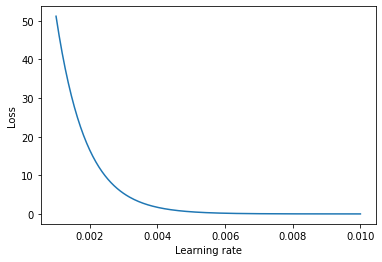

In [ ]:
lr_range_test_UNcensored(GausianLogLikelihoodLoss, batch_size = 100, epochs = 2, start_lr = 1e-3, end_lr = 1e-2, log_view = False, plt_file_name = 'pdf_log_likelihood')

### Grid Search

In [ ]:
train_and_evaluate_net = train_and_evaluate_UNcensored(CHECKPOINT_GLL, GausianLogLikelihoodLoss, log = False, plot = False)

In [ ]:
# conf = {
#     'max_lr': 1e-3,
#     'epochs': 10,
#     'batch': 100,
#     'pct_start': 0.3,
#     'anneal_strategy': 'linear',
#     'base_momentum': 0.85,
#     'max_momentum': 0.95,
#     'div_factor': 10,
#     'final_div_factor': 1e4,
#     'weight_decay': 0
# }
# train_and_evaluate_net(conf)

In [ ]:
# grid_config = [{
#     'max_lr': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
#     'epochs': [10, 20],
#     'batch': [100, 200],
#     'pct_start': [0.45],
#     'anneal_strategy': ['linear'],
#     'base_momentum': [0.85],
#     'max_momentum': [0.95],
#     'div_factor': [10, 5, 2],
#     'final_div_factor': [1e4],
#     'weight_decay': [0]
# }]
# grid_best = grid_search(grid_config, train_and_evaluate_net, CHECKPOINT_GLL, conf_validation = config_validation)
# print(grid_best)

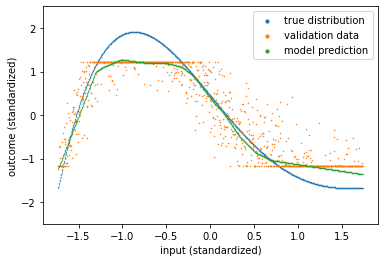

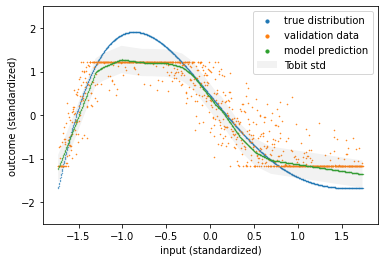

Absolute error - validation 0.21045337617397308
R2 - validation 0.8815284331847661
Absolute error - test 0.4870160222053528
R2 - test 0.812031142913699


In [ ]:
# plot_and_evaluate_model_UNcensored(CHECKPOINT_GLL, GausianLogLikelihoodLoss, isGrid = False)
plot_and_evaluate_model_UNcensored(CHECKPOINT_GLL, GausianLogLikelihoodLoss, isGrid = True)

In [ ]:
# grid_results = t.load(GRID_RESULTS_FILE)
# best_config = grid_results['best']
# best_metrics = grid_results[str(best_config)]
# print(best_config)
# print(best_metrics)

In [ ]:
# print(len(grid_results))